# Starting with DReAMy: encoding, reduction and visualisation

In this notebook, we will start using DReAMy and its basic funcionality. That is, downloading data, collecting embeddings for (some) dream reports, reducing the embeddings sapce and searching for significant patterns in the reduced space. 

In [1]:
! pip install dreamy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 97.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 49.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 25.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.0/213.0 KB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 75.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 11.9 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [2]:
import dreamy

Let's start by getting some dreams. You can stard by dowloading a collection of dream-reports scraped from the DreamBank database, freely availabe from DReAMy's hugging face! 

DReAMy has direct access to two datasets. A smaller English-only (~ 20k), and a larger and multiplingual one (En/De, ~ 30 k). We will start with the En-Only one, has it has descriptive variables (such as gender and year). 

In [3]:
language   = "english" # choose between english/multi
dream_bank = dreamy.get_HF_DreamBank(as_dataframe=True, language=language)

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/22415 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/DReAMy-lib___parquet/DReAMy-lib--DreamBank-dreams-en-98a9abc92d226c3a/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/1 [00:00<?, ?it/s]

As you can see, the file, dowloaded directlty as a pandas DataFrame, as three entires:
- dreams, the dream-reports
- series, the different collection of DreamBank
- description, a brief description of each series

In [23]:
dream_bank.sample(2)

,series,description,dreams,gender,year
5875,blind-f,Blind dreamers (F),I'm at work in the office of a rehab teacher n...,female,mid-1990s
12888,emma,Emma: 48 years of dreams,"I go to Pedro's house, he is fixing his bike. ...",female,1949-1997


Lets now sample a small set of dreams. If you have a more powerfull machine (or you are working on Colab), you can increase the number of report. Note than the whole dataset contains ~ 29 k reports.

In [5]:
n_samples = 20
dream_sample = dream_bank.sample(n_samples).reset_index(drop=True)

Now we get the reports as a list, and use the `.get_encodings` functions of dreamy to extract the encodings. The encodings are the the `[CLS]` token of an LLM. At the moment, you can chose betweem four models, that are combination of small/large Engish-ony/multilingual (BERT / XLM-R).

In [6]:
model_size = "small"   # or large
model_lang = "english" # or multi, for multilingual
device     = "cuda"    # "cpu" for loca/cpu, "cuda" for GPUs

In [7]:
dream_list       = dream_sample["dreams"].tolist()
report_encodings = dreamy.get_encodings(
    dream_list, 
    model_size=model_size,
    language=model_lang, 
    device=device,
)

Loading/Downloading model and tokenizer


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Now that we have our embeddings for each report, we can use the `reduce_space` space function of dreamy. Available method are (for now) limited to `pca` and `t-sne`

In [8]:
X, Y = dreamy.reduce_space(report_encodings, method="pca")

After collecting the cooordinates of the reduced space, we can update the `DataFrame` of our selected sample with them so to facilitate plotting the obtained results.

In [9]:
dream_sample["DR_X"], dream_sample["DR_Y"] = X, Y

To visualise the resuced spece, we will make use of `seabonr`, since it well integrates with pandas. We will plot the 2-D space as a scatter plot, and use the different series as hue.

In [10]:
import seaborn as sns

sns.set_context("talk")
sns.set_style("whitegrid")

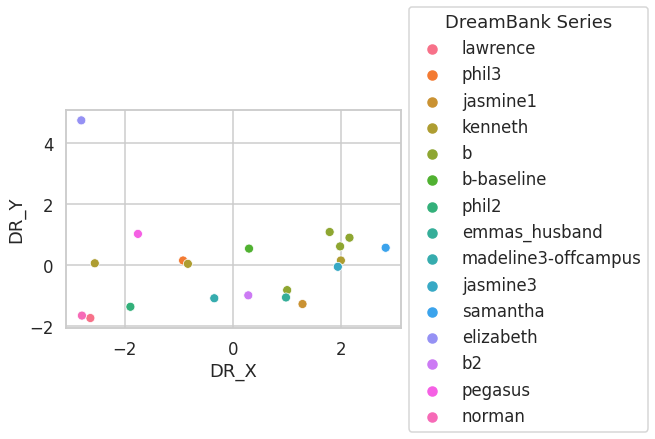

In [11]:
g = sns.scatterplot(
    data=dream_sample, 
    x="DR_X", 
    y="DR_Y", 
    hue="series",
)
g.legend(loc='center left', title="DreamBank Series", bbox_to_anchor=(1, 0.5))

Since noclear pattern can be identified, we will furher use a K-Mean cluster to search for possible implicit clusters in the data. To do so, we can direclty use dreamy's `get_KMeans()` functionality, as shown below.

In [12]:
n_gender_clusters = 2

gender_labels = dreamy.get_KMeans(report_encodings, n_gender_clusters)
dream_sample["KM_gender"] = gender_labels

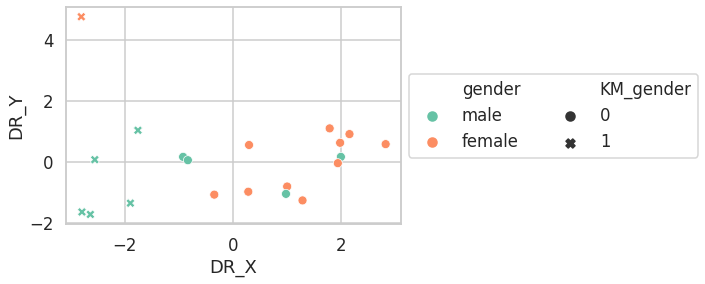

In [13]:
g = sns.scatterplot(
    data=dream_sample, 
    x="DR_X", 
    y="DR_Y", 
    hue="gender",
    palette="Set2",
    style="KM_gender",
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)

In [14]:
n_year_clusters = len(set(dream_sample["year"]))

gender_labels = dreamy.get_KMeans(report_encodings, n_year_clusters)
dream_sample["KM_year"] = gender_labels

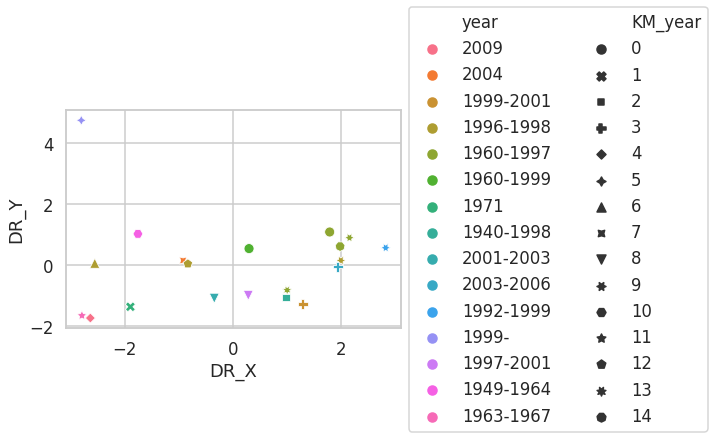

In [15]:
g = sns.scatterplot(
    data=dream_sample, 
    x="DR_X", 
    y="DR_Y", 
    hue="year",
    style="KM_year",
    s=100,
)
g.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=2)